In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import datetime
from pyfolio.timeseries import perf_stats
from utils import plot, rolling_sharpe, plot_rolling_sharpe, plot_rolling_vol
%matplotlib inline

In [2]:
cash = 12000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-06-28_13-47_20180601_20191231_base_fixed.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
micro_contracts = df[df.contract.str.startswith('M')]
macro_contracts = df[~df.contract.str.startswith('M')]
micro_contracts['amount'] /= 10
df = pd.concat([macro_contracts, micro_contracts]).sort_index()
df.contract = df.contract.str.strip('M')
df['contract'] = df['contract'].apply(lambda x: x[:2])
df.contract = df.contract.str.strip()

In [4]:
pnl = df.groupby('contract').realizedPNL.sum()
pnl['total'] = pnl.sum()
pnl

contract
ES       22802.60
GC        6466.64
NQ       34341.80
YM       31639.80
total    95250.84
Name: realizedPNL, dtype: float64

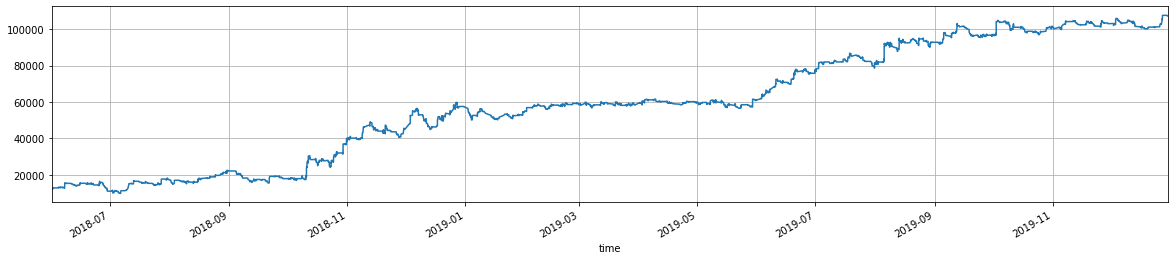

In [5]:
df.cash.plot(figsize=(20,4), grid=True);

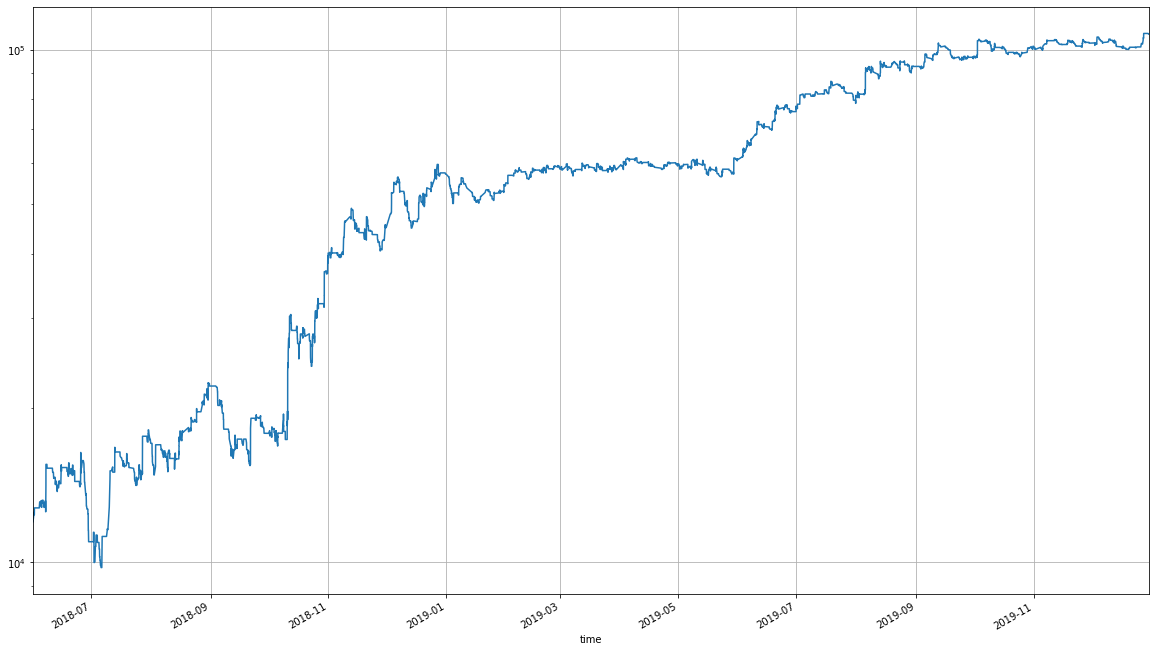

In [6]:
df.cash.plot(figsize=(20,12), grid=True, logy=True);

In [7]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, aggfunc='sum', columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [8]:
#monthly average number of transactions
daily_count = df.groupby('contract').action.resample('B').count()
zero_index = set(daily_count.index.get_level_values(0))
monthly_count = daily_count.groupby('contract').resample('M', level=1).mean()
average_monthly_contracts = pd.DataFrame({contract: monthly_count[contract] for contract in zero_index})
average_monthly_contracts

,YM,ES,GC,NQ
time,,,,
2018-06-30,1.500000,0.666667,2.666667,4.380952
2018-07-31,0.818182,0.590909,2.818182,2.727273
2018-08-31,1.130435,0.478261,3.173913,3.130435
2018-09-30,1.100000,0.700000,3.000000,4.000000
2018-10-31,2.521739,1.565217,2.826087,7.043478
2018-11-30,1.409091,0.954545,2.181818,6.136364
2018-12-31,2.476190,1.571429,2.285714,6.714286
2019-01-31,1.521739,0.826087,2.000000,4.521739
2019-02-28,1.300000,0.550000,1.850000,3.600000


In [9]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     344
 GC    1208
 NQ    1892
 YM     612
 Name: action, dtype: int64, 4056)

In [10]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    0.834951
 GC    2.932039
 NQ    4.592233
 YM    1.485437
 Name: action, dtype: float64, 9.844660194174757)

In [11]:
# commission paid
comm = df.groupby('contract').commission.sum()
comm['total'] = comm.sum()
comm

contract
ES        722.40
GC       2923.36
NQ       3973.20
YM       1285.20
total    8904.16
Name: commission, dtype: float64

In [12]:
# commission paid as percent of pnl
round((comm/pnl) *100, 1)

contract
ES        3.2
GC       45.2
NQ       11.6
YM        4.1
total     9.3
dtype: float64

In [13]:
# per trade stats (pro rated per macro contract)
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss', 
                                'win_ratio', 'EV/contract', 'contracts_per_position', 'number_of_positions', 
                                'number_of_contracts'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    d['pnl_per_contract'] = d.realizedPNL / d.amount
    row['average_PNL'] = round(d['pnl_per_contract'].mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0])['pnl_per_contract'].mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0])['pnl_per_contract'].mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV/contract'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['contracts_per_position'] = round(d.amount.sum() / d.amount.count(), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    row['number_of_contracts'] = d.amount.sum()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV/contract,contracts_per_position,number_of_positions,number_of_contracts
GC,0.36,10.71,485.25,-259.23,1.87,8.78,1.0,604.0,604.0
NQ,0.41,36.30,456.51,-252.08,1.81,38.44,1.0,946.0,946.0
YM,0.41,103.40,808.50,-377.00,2.14,109.05,1.0,306.0,306.0
ES,0.45,132.57,984.76,-558.15,1.76,136.16,1.0,172.0,172.0
total,0.40,46.97,569.08,-296.70,1.92,49.61,1.0,2028.0,2028.0


In [14]:
edge = results['win_ratio'] - ((1-results['success_rate'])/ results['success_rate'])
edge

GC       0.092222
NQ       0.370976
YM       0.700976
ES       0.537778
total    0.420000
dtype: float64

In [15]:
daily = by_contract.resample('B').sum()
total_cumsum = (daily['total'].cumsum() + cash).shift(1).fillna(cash)
daily_non_total = daily[daily.columns.drop('total')] * len(daily.columns.drop('total'))
daily_scaled = daily_non_total.copy()
daily_scaled['total'] = daily['total']
daily_scaled

contract,ES,GC,NQ,YM,total
time,,,,,
2018-06-01,0.0,2100.64,986.4,0.0,771.76
2018-06-04,0.0,0.00,486.4,0.0,121.60
2018-06-05,0.0,-1238.72,1289.6,1243.2,323.52
2018-06-06,0.0,-899.36,-756.8,0.0,-414.04
2018-06-07,5683.2,-2518.72,1503.2,6243.2,2727.72
...,...,...,...,...,...
2019-12-24,0.0,1580.64,0.0,0.0,395.16
2019-12-25,0.0,0.00,0.0,0.0,0.00
2019-12-26,0.0,6340.64,0.0,0.0,1585.16


In [16]:
returns = daily.divide(total_cumsum, axis=0)
returns

contract,ES,GC,NQ,YM,total
time,,,,,
2018-06-01,0.000000,0.043763,0.020550,0.000000,0.064313
2018-06-04,0.000000,0.000000,0.009521,0.000000,0.009521
2018-06-05,0.000000,-0.024019,0.025005,0.024105,0.025092
2018-06-06,0.000000,-0.017012,-0.014315,0.000000,-0.031327
2018-06-07,0.110975,-0.049183,0.029353,0.121910,0.213056
...,...,...,...,...,...
2019-12-24,0.000000,0.003918,0.000000,0.000000,0.003918
2019-12-25,0.000000,0.000000,0.000000,0.000000,0.000000
2019-12-26,0.000000,0.015654,0.000000,0.000000,0.015654


In [17]:
returns_scaled = daily_scaled.divide(total_cumsum, axis=0)

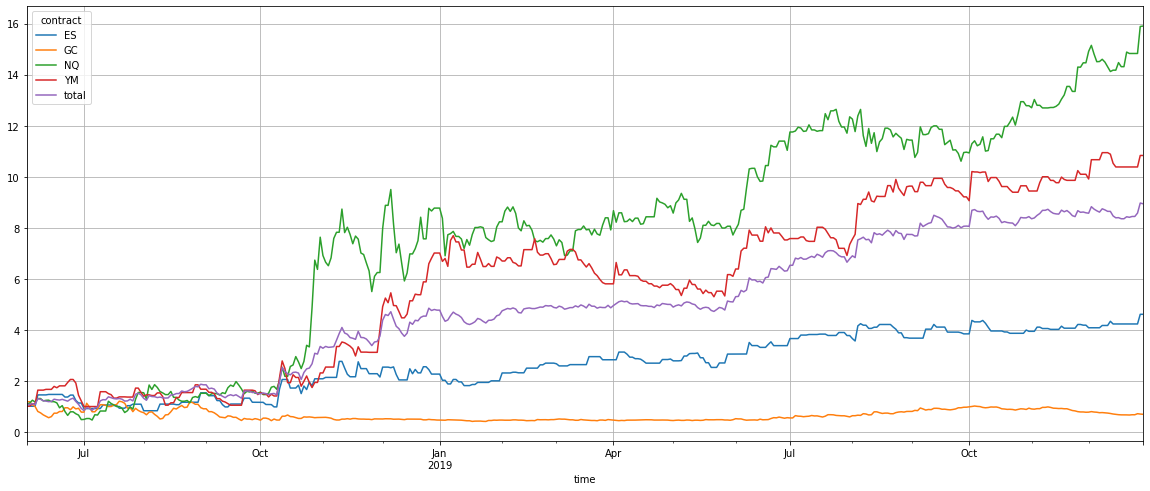

In [18]:
returns_index = (returns_scaled + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [19]:
# instrument correlations
log_returns = np.log(returns_scaled + 1)
log_returns.corr()

contract,ES,GC,NQ,YM,total
contract,,,,,
ES,1.000000,-0.054385,0.161865,0.452078,0.624238
GC,-0.054385,1.000000,0.086980,0.086668,0.412260
NQ,0.161865,0.086980,1.000000,0.266915,0.660767
YM,0.452078,0.086668,0.266915,1.000000,0.741076
total,0.624238,0.412260,0.660767,0.741076,1.000000


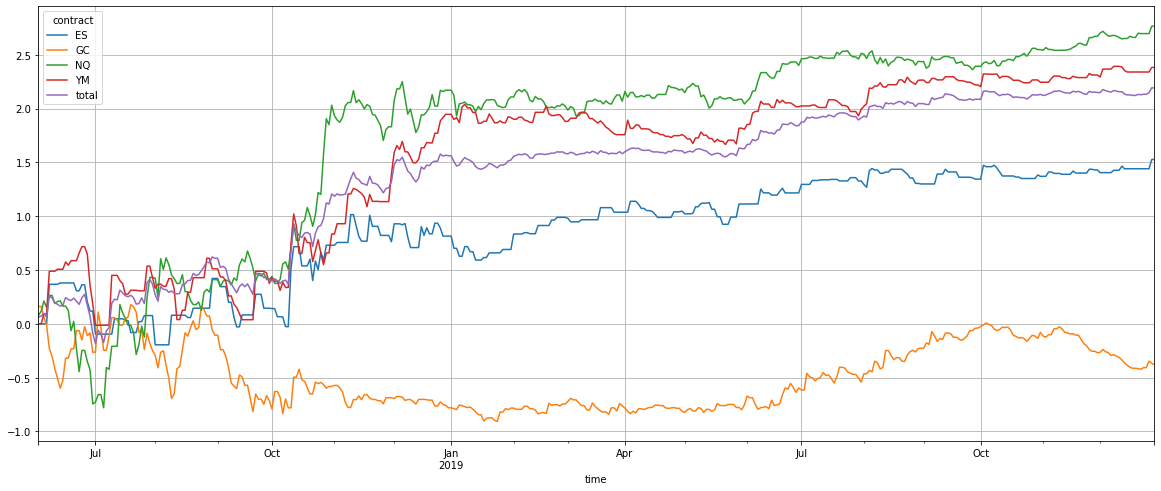

In [20]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

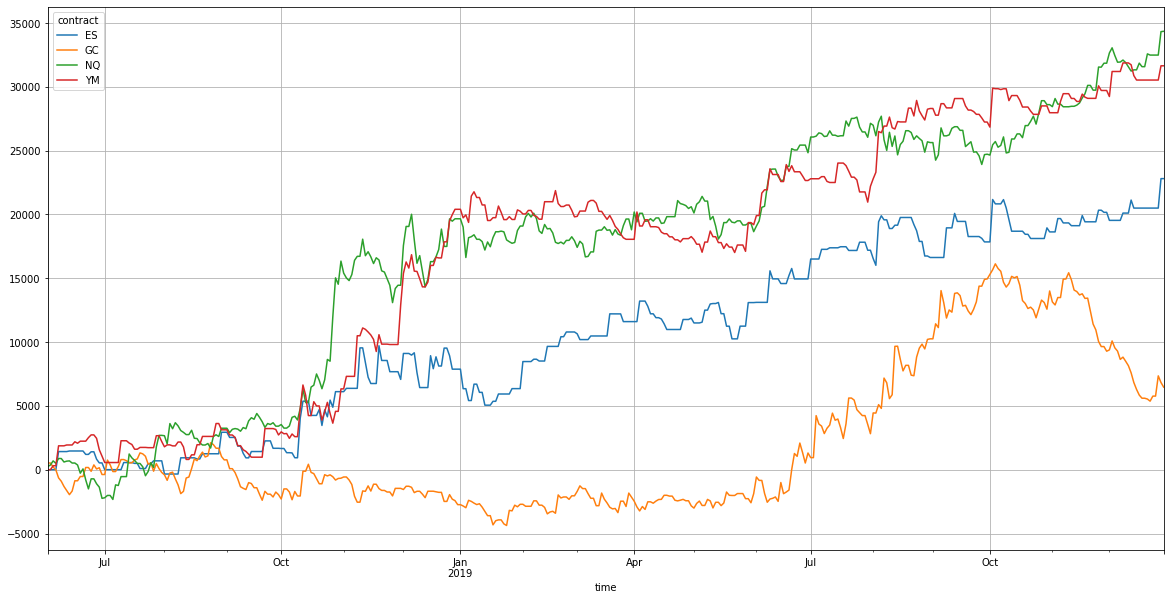

In [21]:
# dollar returns cummulative
by_contract.resample('B').sum().drop('total', axis=1).cumsum().plot(figsize=(20,10), grid=True);

In [22]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(returns_scaled[col])
stats

,ES,GC,NQ,YM,total
Annual return,1.544478,-0.207421,4.430835,3.293609,2.817806
Cumulative returns,3.603857,-0.316179,14.901882,9.829654,7.937570
Annual volatility,1.120150,1.031601,1.322005,1.255612,0.741603
Sharpe ratio,1.322266,0.262973,1.883189,1.709534,2.153618
Calmar ratio,3.532956,-0.313111,6.841030,6.357247,7.672873
Stability,0.867497,0.013838,0.760801,0.817783,0.881290
Max drawdown,-0.437163,-0.662452,-0.647685,-0.518087,-0.367243
Omega ratio,1.539103,1.057705,1.539626,1.634100,1.651556
Sortino ratio,2.890628,0.449943,3.798021,3.878066,4.800531
Skew,3.846088,1.608613,2.125027,3.327438,2.719891


In [23]:
#non-scaled returns
stats_non_scaled = pd.DataFrame()
for col in daily.columns:
    stats_non_scaled[col] = perf_stats(returns[col])
stats_non_scaled

,ES,GC,NQ,YM,total
Annual return,0.394574,0.035809,0.766260,0.630769,2.817806
Cumulative returns,0.722466,0.059207,1.534630,1.224563,7.937570
Annual volatility,0.280037,0.257900,0.330501,0.313903,0.741603
Sharpe ratio,1.322266,0.262973,1.883189,1.709534,2.153618
Calmar ratio,3.362987,0.172956,3.729884,4.071493,7.672873
Stability,0.862643,0.272956,0.761612,0.818400,0.881290
Max drawdown,-0.117328,-0.207039,-0.205438,-0.154923,-0.367243
Omega ratio,1.539103,1.057705,1.539626,1.634100,1.651556
Sortino ratio,2.890628,0.449943,3.798021,3.878066,4.800531
Skew,3.846088,1.608613,2.125027,3.327438,2.719891


In [24]:
# monthly returns in percent
log_r = np.log(returns + 1)
monthly_log_returns = log_r.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
monthly_returns = round(monthly_returns, 4) * 100
monthly_returns

contract,ES,GC,NQ,YM,total
time,,,,,
2018-06-30,4.79,-3.97,-14.28,7.80,-8.57
2018-07-31,-0.19,4.09,42.70,9.82,58.37
2018-08-31,11.46,6.53,2.24,3.98,27.06
2018-09-30,-5.63,-12.88,0.83,-0.89,-19.11
2018-10-31,21.74,5.34,57.98,17.52,124.68
2018-11-30,2.48,-2.33,-4.02,16.99,12.11
2018-12-31,2.51,-2.22,11.08,15.99,27.16
2019-01-31,-2.71,0.09,-0.92,-0.27,-3.87
2019-02-28,8.05,1.09,-1.96,-0.72,6.38


In [25]:
monthly_returns.total.mean(), monthly_returns.total.median()

(15.202631578947367, 4.6)

In [26]:
monthly_returns.sort_values('total', ascending = False).total

time
2018-10-31    124.68
2018-07-31     58.37
2018-12-31     27.16
2018-08-31     27.06
2019-06-30     24.05
2019-08-31     14.08
2018-11-30     12.11
2019-07-31      7.40
2019-02-28      6.38
2019-10-31      4.60
2019-09-30      4.25
2019-12-31      4.13
2019-04-30      2.76
2019-05-31      1.92
2019-11-30      1.78
2019-03-31     -0.33
2019-01-31     -3.87
2018-06-30     -8.57
2018-09-30    -19.11
Name: total, dtype: float64

In [27]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

contract
ES        72.0
GC         6.0
NQ       153.0
YM       122.0
total    794.0
dtype: float64

In [28]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2019-08-05 21:22:30,ES,BUY,2843.00,3408.30
2019-10-02 21:00:00,ES,BUY,2893.75,3320.80
2019-07-03 00:21:30,GC,SELL,1433.40,3245.16
2019-08-05 21:19:00,YM,BUY,25615.00,3190.80
2018-11-08 20:40:00,YM,SELL,26092.00,3180.80
...,...,...,...,...
2018-12-18 21:49:00,ES,BUY,2559.75,-1204.20
2018-12-20 12:21:30,ES,BUY,2508.00,-1204.20
2018-12-10 13:56:30,ES,BUY,2638.75,-1329.20


In [29]:
daily.sort_values('total', ascending=False)

contract,ES,GC,NQ,YM,total
time,,,,,
2019-08-05,3408.3,660.32,1073.8,3190.8,8333.22
2019-10-02,3320.8,365.48,799.0,3050.8,7536.08
2018-12-03,2033.3,-89.68,3106.6,2455.8,7506.02
2018-10-11,1337.4,1940.64,1513.2,1857.4,6648.64
2018-10-10,3095.8,0.00,902.2,2191.6,6189.60
...,...,...,...,...,...
2018-11-21,-1154.2,-144.84,-853.4,-739.2,-2891.64
2019-01-02,-1529.2,-104.84,-653.4,-669.2,-2956.64
2018-10-22,-1245.9,0.00,-657.6,-1113.4,-3016.90


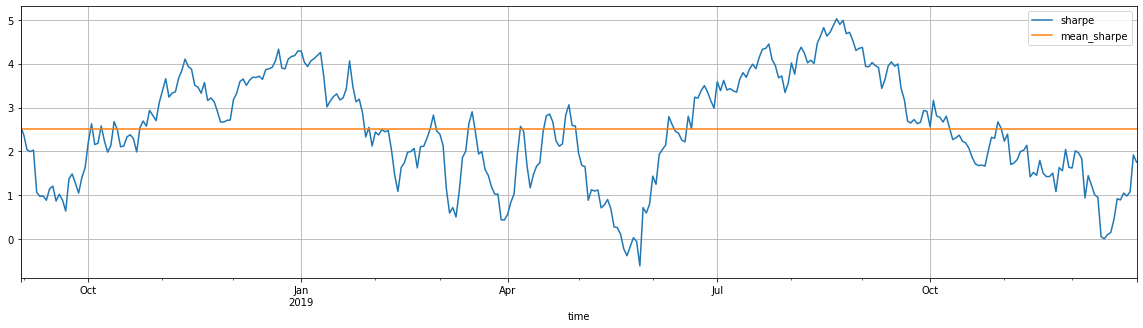

In [30]:
plot_rolling_sharpe(returns.total, 3)

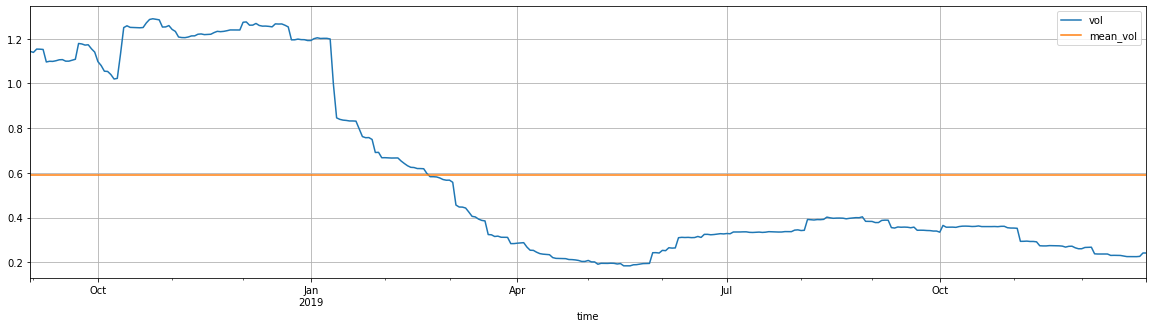

In [31]:
plot_rolling_vol(returns.total, 3)